# Building Micrograd from Scratch

#### This is a set-by-step explanation of backpropagation and training of neural networks.

**References:** 
https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

Import the necessary libraries that we will use in this notebook to first understand the basics of derivatives and then build the backpropagation algorithm from scratch.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### I. Understanding Derivatives

Define any function f(x) for this example

In [2]:
def f(x):
    # Random scalar value function that inputs a value of 'x' and returns a value of 'y'
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

Create a set of scalar values for x so that we can understand the shape of the function f(x)

In [4]:
xs = np.arange(-5, 5, 0.25)
# Print the 'x' inputs
print(f'Inputs of x: \n {xs} \n')

ys = f(xs)
# Print the 'y' outputs
print(f'Outputs of y: \n {ys} \n')

Inputs of x: 
 [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75] 

Outputs of y: 
 [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875] 



Plot the function f(x) and its outputs, 'y'

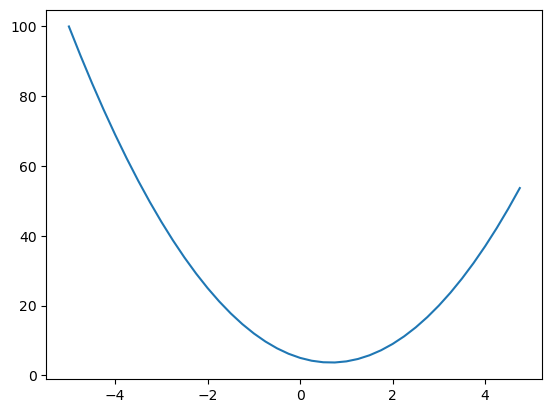

In [5]:
plt.plot(xs, ys)

***The derivative equation:***

$$
\frac{{df}}{{dx}} = \lim_{{h \to 0}} \frac{{f(x + h) - f(x)}}{{h}}
$$

In [6]:
# Set the value of h to be very small (moving a very small amount of the x-axis)
h = 0.001
# Define a value of 'x' where we want to calculate the derivative
x = 3
# Calculate the derivative of f(x) at x = 3 using the derivative equation above.
print(f'The value at 3 + h: {f(x + h)}')
print(f'The difference in f(3+h) and f(x): {f(x+h) - f(x)}')
print(f'The slope (rise-over-run) at f(x) (a.k.a., the derivative): {(f(x+h) - f(x))/h}')

The value at 3 + h: 20.014003000000002
The difference in f(3+h) and f(x): 0.01400300000000243
The slope (rise-over-run) at f(x) (a.k.a., the derivative): 14.00300000000243


We can continue to make the value of h smaller and smaller (*h approaching 0*) to get a more accurate derivative value.

Next, evaluate the derivative of the function f(x) at the point x = 2/3 (which has previously been calculated to be the minimum).

In [7]:
# Set the value of h to be very small (moving a very small amount of the x-axis)
h = 0.000001
# Define a value of 'x' where we want to calculate the derivative
x = 2/3
# Calculate the derivative of f(x) at x = 3 using the derivative equation above.
print(f'The value at 2/3 + h: {f(x + h)}')
print(f'The difference in f(2/3+h) and f(x): {f(x+h) - f(x)}')
print(f'The slope (rise-over-run) at f(x) (a.k.a., the derivative): {(f(x+h) - f(x))/h}')

The value at 2/3 + h: 3.6666666666696663
The difference in f(2/3+h) and f(x): 2.999378523327323e-12
The slope (rise-over-run) at f(x) (a.k.a., the derivative): 2.999378523327323e-06


#### Now, lets look at a more complex case of a function with multiple variables.

In [8]:
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [9]:
# Set the incredimental h increase
h = 0.0001

# Define the inputs
a = 2.0
b = -3.0
c = 10
d = a*b + c

# Calculat the derivative of 'd' with respct to 'a' {'d(a)'}
d1 = a*b + c
a += h      #1
d2 = a*b + c

print("The derivative of 'd' with respect to 'a'")
print('d1 = ', d1)
print('d2 = ', d2)
print('slope = ', (d2 - d1)/h)

# This same process can be applied to 'b' and 'c' by replace 'a' @ #1


The derivative of 'd' with respect to 'a'
d1 =  4.0
d2 =  3.999699999999999
slope =  -3.000000000010772


### II. Create a Class, `Value` 

- This class stores values objects and defines the basic operations on them.

In [10]:
class Value:
    """
    Represents a value with automatic differentiation capabilities.
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initializes a Value object.

        Args:
            data: The numerical value of the object.
            _children: A tuple of child Value objects.
            _op: The operation performed to obtain the current Value object.
            label: A label for the Value object.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        Returns a string representation of the Value object.
        """
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        Adds two Value objects or a Value object and a numerical value.

        Args:
            other: The Value object or numerical value to be added.

        Returns:
            A new Value object representing the sum.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplies two Value objects or a Value object and a numerical value.

        Args:
            other: The Value object or numerical value to be multiplied.

        Returns:
            A new Value object representing the product.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Raises the Value object to a power.

        Args:
            other: The power to raise the Value object to.

        Returns:
            A new Value object representing the result of the exponentiation.
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        """
        Multiplies a numerical value with the Value object.

        Args:
            other: The numerical value to be multiplied.

        Returns:
            A new Value object representing the product.
        """
        return self * other

    def __truediv__(self, other):
        """
        Divides the Value object by another Value object or a numerical value.

        Args:
            other: The Value object or numerical value to divide by.

        Returns:
            A new Value object representing the quotient.
        """
        return self * other**-1

    def __neg__(self):
        """
        Negates the Value object.

        Returns:
            A new Value object representing the negation.
        """
        return self * -1

    def __sub__(self, other):
        """
        Subtracts another Value object or a numerical value from the Value object.

        Args:
            other: The Value object or numerical value to subtract.

        Returns:
            A new Value object representing the difference.
        """
        return self + (-other)

    def __radd__(self, other):
        """
        Adds a numerical value to the Value object.

        Args:
            other: The numerical value to add.

        Returns:
            A new Value object representing the sum.
        """
        return self + other

    def tanh(self):
        """
        Computes the hyperbolic tangent of the Value object.

        Returns:
            A new Value object representing the hyperbolic tangent.
        """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        """
        Computes the exponential of the Value object.

        Returns:
            A new Value object representing the exponential.
        """
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        """
        Performs backpropagation to compute the gradients of the Value objects.
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [11]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
# Test some values for a, c, ...
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

print("Addition of a+b: ", a + b)       # Internally, Python is calling 'a.__add__(b)'
print("Multiplication of a+b: ", a * b)
print(f'(a * b) + c = {d}')

Addition of a+b:  Value(data=-1.0)
Multiplication of a+b:  Value(data=-6.0)
(a * b) + c = Value(data=4.0)


In [13]:
print(f"The child values that are used for to 'd': {d._prev}")
print(f"The operation that was used to get 'd' from the children: {d._op}")

The child values that are used for to 'd': {Value(data=10.0), Value(data=-6.0)}
The operation that was used to get 'd' from the children: +


### III. Computational Graph for Complex Values

- Next, because the values we are working with are about to become more complex, we want a way to neatly represent the values using a computational graph.

In [14]:
# %pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangulat ('record') node for it
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

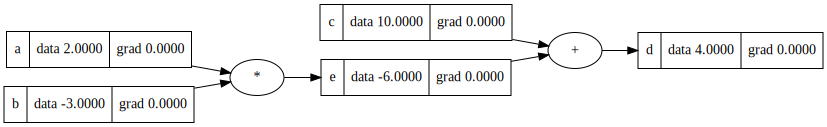

In [15]:
draw_dot(d)

In [16]:
# One Layer Deeper: Create an output for this simple network, which will be labeled as 'L'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [17]:
L.grad = 1

# The gradient of f is the value of d
f.grad = 4.0
# The gradient of d is the value of f
d.grad = -2.0

# The rest of the values
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0



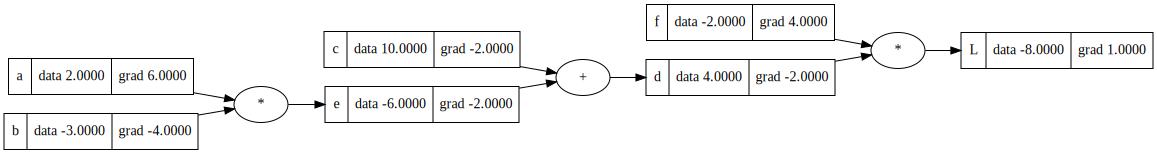

In [18]:
# Draw the new network with the output
draw_dot(L)

For the example above, we will be interested in the deterivate of the output, 'L', with respect to the various inputs, 'a, b, c, ...'

So, we will go back to our `Value` class and add a 'grad' method to store the gradient of the output with respect to the input values.

In [19]:
# You can use this function to check the derivative of all of the values in the network

def sample_diriv():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h
    
    print('The baseline Derivative of L (with respect to itself):')
    print((L2 - L1)/h)

sample_diriv()

The baseline Derivative of L (with respect to itself):
0.9999999999976694


#### Example/Application of the Gradient:
- If we want to increase the final value of L, we can 'nudge' the input values in the direction of the gradient.

In [20]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.4352


### IV. Example of the Type of Activation Functions Used in Neural Networks

- #### Tanh Activation Function

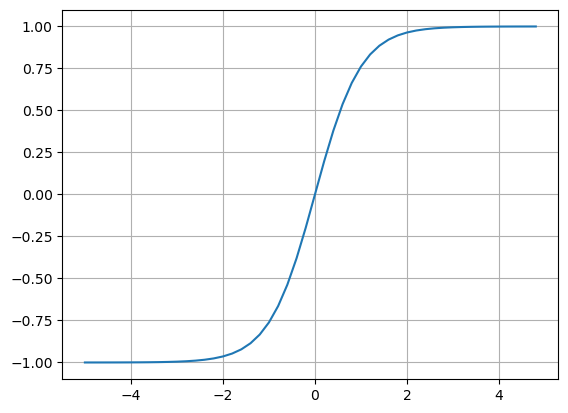

In [21]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

### V. Example of Working Through a Neural Network

#### Example Neuron:
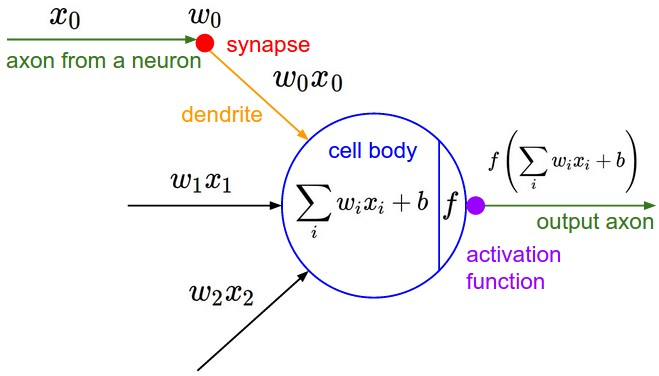

In [22]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# Equation: x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'     # 'o' is short for output


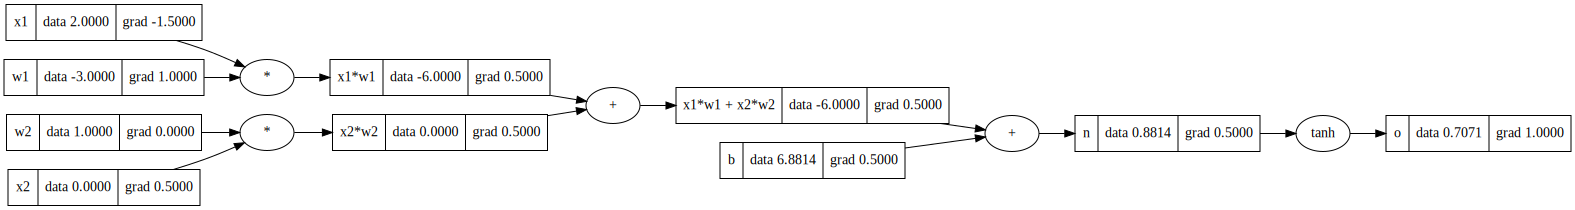

In [23]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

### VI. Topological Representation

-  Next, we can build a topoligical sort function to sort the nodes in the graph so that we can avoid having to manually sort and perform the _backward operation on each of the nodes.

In [24]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Now that we know this works, we will go back to the `Value` class and add a `backward` method to compute the gradients of the output with respect to the input values.

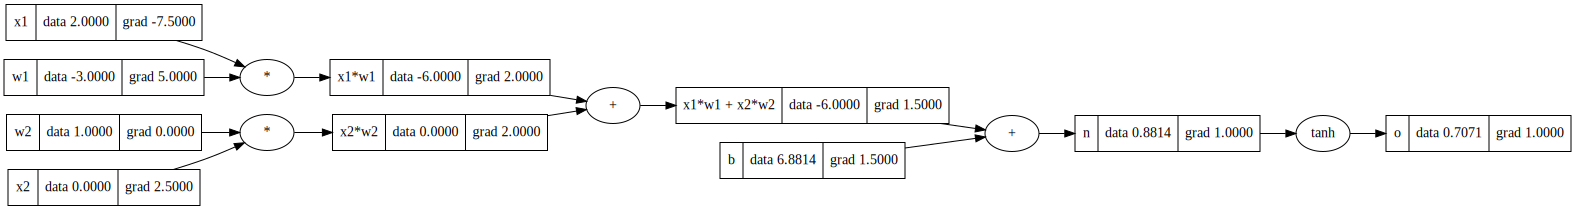

In [25]:
o.backward()

draw_dot(o)

### V. Spelling Out the Tanh Function for the Neuron

- We will now spell out the tanh function for the neuron to see how all the individual parts of the tanh function contribute to the final output and the gradients of the output with respect to the input values.

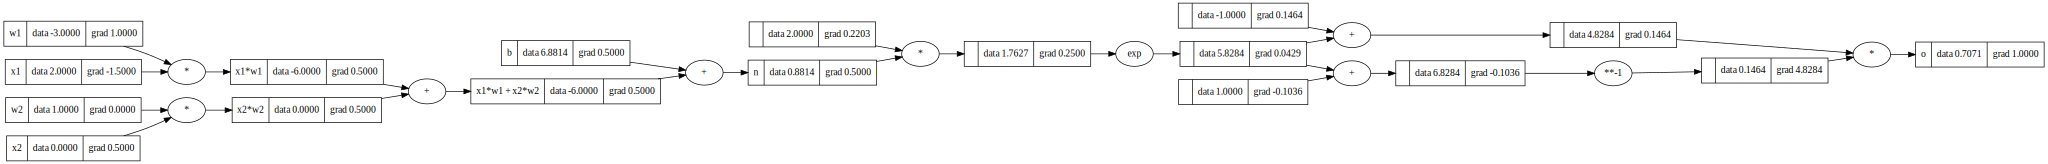

In [26]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# Equation: x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Equations for tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)

# Define 'o' as the output and perform backpropagaion
o.label='o'
o.backward()
draw_dot(o)


### VI. Everything Done So Far, But with PyTorch


In [28]:
# %pip install torch
import torch

Note: you may need to restart the kernel to use updated packages.


In [29]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### VII. Now, Building Out a Neural Network

- Now, we will build out a neural network library (multi-layer perceptron) using the `Value` class (micrograd) that we have built so far.

In [93]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
        
        
x = [2.0, 3.0, -1.0]
n = MLP(2, [4, 4, 1])
n(x)

Value(data=-0.5264995477115503)

### VIII. Creating a Tiny Dataset & Writing a Loss Function

In [94]:
# Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Demonstration that as it currently stand, the network does not work well (without loss)
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5264995477115503),
 Value(data=-0.6577217292625316),
 Value(data=-0.6941313205767553),
 Value(data=-0.6290502755144116)]

In [95]:
# Calculate the Squared Error of this Neural Network (The Loss)
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=2.3302008691635674),
 Value(data=0.11715441461903173),
 Value(data=0.09355564905211963),
 Value(data=2.6538048001535803)]

In [96]:
# The final Loss of this NNs predictions
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.194715732988299)

In [140]:
# Create a loop to minimize the loss function with 20 epochs (iterations)
for k in range(20):
    
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass
    for p in n.parameters():    # Reset the grad's to 0, so that the backward pass accumulates the loss derivatives into the grad's
        p.grad = 0.0
    loss.backward()
    
    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)


0 0.0005198069091207397
1 0.0005191310498495279
2 0.0005184569287783352
3 0.0005177845392234152
4 0.0005171138745352275
5 0.0005164449280982287
6 0.0005157776933306289
7 0.0005151121636842507
8 0.0005144483326442222
9 0.0005137861937288231
10 0.0005131257404892657
11 0.0005124669665094734
12 0.0005118098654058845
13 0.0005111544308272359
14 0.0005105006564543555
15 0.0005098485359999993
16 0.0005091980632085955
17 0.0005085492318560709
18 0.0005079020357496614
19 0.0005072564687277052


In [141]:
ypred

[Value(data=0.9942425822270822),
 Value(data=-0.9908042491958298),
 Value(data=-0.9869849137022171),
 Value(data=0.9851624023128857)]